In [1]:
import numpy as np
from numpy.typing import NDArray
from typing import Optional
from typing import List
import copy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import wandb


In [2]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'nn.ipynb'

In [3]:
class LinearLayer:
    def __init__(self,sizeIn:int,sizeOut:int,weights: Optional[NDArray[np.float64]] = None,RndWths=True,reg=False,reg_type='l2'):
        reg_list={'l1','l2'}
        if reg:
            if reg_type not in reg_list:
                raise ValueError(f"!{reg_list}")
        self.reg = reg
        self.reg_type=reg_type
        self.sizeIn=sizeIn
        self.sizeOut=sizeOut
        if RndWths:
            self.weights=np.random.normal(loc=0.0, scale=1.0, size=(sizeIn,sizeOut))
        else:
            if weights == None:
                raise ValueError("!")
            self.weights=weights
            
            
    def forwardPropagation(self, x: NDArray[np.float64])-> NDArray[np.float64]:
        if x.shape[1]!=(self.weights).shape[0]:
            raise ValueError("!")
        self.X=x
        return x.dot(self.weights)

    def backwardPropagation(self, gradPrev:NDArray[np.float64])-> NDArray[np.float64]:
        self.weightsDiff=(self.X.T).dot(gradPrev)
        return gradPrev.dot(self.weights.T)

    def updateWeights(self,lr:float):
        lmbd_reg=0.05
        print(self.weightsDiff.shape)
        if not self.reg:
            self.weights=self.weights-lr*(self.weightsDiff)
        elif self.reg_type=='l2':
            self.weights=self.weights-lr*(self.weightsDiff+lmbd_reg*self.weights)
        else:
            self.weights=self.weights-lr*(self.weightsDiff+lmbd_reg*np.sign(self.weights))
        self.weightsDiff = 0

    def predict(self, x: NDArray[np.float64]) -> NDArray[np.float64]:
        if x.shape[1]!=(self.weights).shape[0]:
            raise ValueError("!")
        return x.dot(self.weights) 

In [4]:
class ReLu:
    def __init__(self):
        pass
        
    def forwardPropagation(self, x: NDArray[np.float64])-> NDArray[np.float64]:
        self.X=x
        return np.where(x>0,x,0)
        
    def predict(self, x: NDArray[np.float64])-> NDArray[np.float64]:
        return np.where(x>0,x,0)

    def backwardPropagation(self, gradPrev: NDArray[np.float64])-> NDArray[np.float64]:
        return np.where(self.X>0,1,0)*gradPrev

In [22]:
class Logistic:
    def __init__(self):
        pass
        
    def forwardPropagation(self, x: NDArray[np.float64])-> NDArray[np.float64]:
        self.X=x
        return self.sigmoid(x)   

    def predict(self, x: NDArray[np.float64])-> NDArray[np.float64]:
        return self.sigmoid(x)  
    
    def sigmoid(self, x):
        x = np.array(x, dtype=np.float64)
        x = np.clip(x, -1000, 1000)   
        return 1/(1 + np.exp(-x))

    def backwardPropagation(self, gradPrev: NDArray[np.float64])-> NDArray[np.float64]:
        return self.sigmoid(self.X)*(1-self.sigmoid(self.X))*gradPrev

In [6]:
class BinaryCrossEntropy:
    def __init__(self):
        pass

    def loss(self,y: NDArray[np.float64],predProbability: NDArray[np.float64]):
        if y.shape[0]!=predProbability.shape[0]:
            raise ValueError("!")
        epsilon = 1e-7
        p = np.clip(predProbability, epsilon, 1 - epsilon)
        return -(np.mean(y*np.log(p)+(1-y)*np.log(1-p)))

    def calcGrad(self,y: NDArray[np.float64],predProbability: NDArray[np.float64]):
        epsilon = 1e-7
        p = np.clip(predProbability, epsilon, 1 - epsilon)
        gr=((p-y)/(p*(1-p)))
        return gr
        #return ((y-p)/(p*(1-p)))

In [7]:
class NeutralNetwork:
    def __init__(self,layers:List,lr:float = 0.5):
        for i in range(len(layers)):
            if isinstance(layers[i], LinearLayer):
                for j in range(i+1,len(layers)):
                    if isinstance(layers[j], LinearLayer):
                        if (layers[i].sizeOut!=layers[j].sizeIn):
                            raise ValueError("!")
                        else:
                            i=j-1
                            break;
                break;
                        
        self.layers = layers
        self.lr = lr

    def forwardPropagation(self,data:NDArray[np.float64]):
        input=data
        for layer in self.layers:
            input=layer.forwardPropagation(input)
        self.out=input

    def predict(self,data:NDArray[np.float64]):
        input=data
        for layer in self.layers:
            input=layer.predict(input)
        self.out=input

    def backwardPropagation(self,lossFuncGrad:NDArray[np.float64]):
        input=lossFuncGrad
        for layer in self.layers[::-1]:
            input=layer.backwardPropagation(input)
        self.out=input

    def updateWeights(self):
        for layer in self.layers[::-1]:
            if isinstance(layer, LinearLayer):
                layer.updateWeights(self.lr)
        

In [8]:
def Accuracy(y: NDArray[np.float64],predProbability: NDArray[np.float64])->float:
    y_pred=np.where(predProbability>=0.5,1,0)
    true_pred=np.sum(True==(y_pred==y))
    return true_pred/y.shape[0]

In [16]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data = pd.concat([train, test], sort=False).reset_index(drop=True)
data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
1308,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


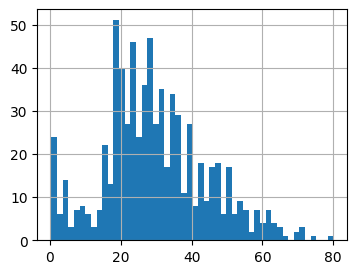

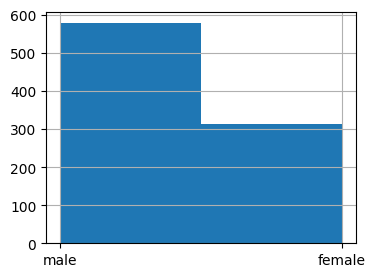

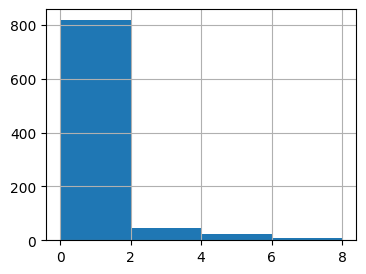

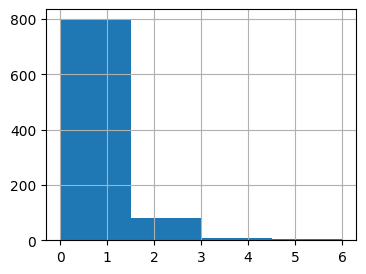

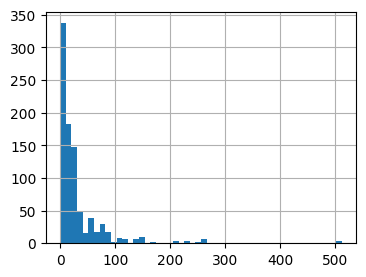

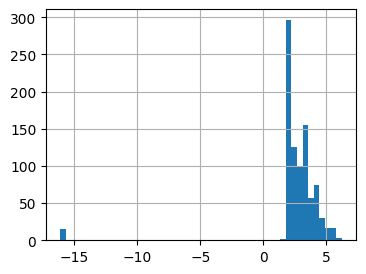

In [17]:
plt.figure()
train['Age'].hist(bins=50, figsize=(4, 3))
plt.figure()
train['Sex'].hist(bins=2, figsize=(4, 3))
plt.figure()
train['SibSp'].hist(bins=4, figsize=(4, 3))
plt.figure()
train['Parch'].hist(bins=4, figsize=(4, 3))
plt.figure()
train['Fare'].hist(bins=50, figsize=(4, 3))
plt.figure()
shifted_fare = train['Fare'] + 1e-7 
log_fare = np.log(shifted_fare)
pd.Series(log_fare).hist(bins=50, figsize=(4, 3))
plt.show()

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

data['Age'] = data.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
rare_titles = ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 
               'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
data['Title'] = data['Title'].replace(rare_titles, 'Rare')
title_mapping = {"Master":0, "Miss":1, "Ms":1, "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3}
data['Title'] = data['Title'].map(title_mapping)
data['Title'] = data['Title'].fillna(3)

data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

data = pd.get_dummies(data, columns=['Embarked'], drop_first=True)

data = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

data['Fare'] = np.log1p(data['Fare'])

scaler = StandardScaler()
num_features = ['Age', 'Fare']
data[num_features] = scaler.fit_transform(data[num_features])

train_processed_t = data[:len(train)].copy()
y_train = train_processed_t['Survived']
train_processed_t = train_processed_t.drop('Survived', axis=1)
test_processed_t = data[len(train):].copy()

train_processed_t.tail()


,Pclass,Sex,Age,SibSp,Parch,Fare,Title,FamilySize,IsAlone,Embarked_Q,Embarked_S
886,2,0,-0.171147,0,0,-0.351432,3,1,1,False,True
887,1,1,-0.776601,0,0,0.469818,1,1,1,False,True
888,3,1,-0.549555,1,2,0.224602,1,4,0,False,True
889,1,0,-0.246828,0,0,0.469818,2,1,1,False,False
890,3,0,0.207262,0,0,-0.836997,2,1,1,True,False


In [23]:
nn_test = NeutralNetwork(
    [LinearLayer(11,32,reg=True,reg_type='l1'),
    ReLu(),
    LinearLayer(32,1,reg=True),
    Logistic()],lr=0.0002
)

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

In [25]:
run = wandb.init(project="nn.ipynb",
                 config = {
                        "learning_rate": 0.0002,
                        "batch_size": 10  
                          }
)


num_epoch=10000
lossFunct=BinaryCrossEntropy()
for _ in range(num_epoch):
    random_row = train_processed_t.sample(n=10)
    ans=np.array([y_train[idx] for idx in random_row.index])
    ans=ans.reshape(10,1)
    #print(random_row.shape)
    nn_test.forwardPropagation(random_row)
    #loss=lossFunc.loss(ans,nn.out)
    #print (loss)
    gradloss=lossFunct.calcGrad(ans,nn_test.out)
    #print(ans.shape)
    #print(nn.out.shape)
    #print(gradloss.shape)
    nn_test.backwardPropagation(gradloss)
    nn_test.updateWeights()

    #print(train_processed.shape)
    nn_test.predict(train_processed_t)

    #print(Y.shape)
    #print((nn.out).squeeze().shape)
    acc = Accuracy(y_train,(nn_test.out).squeeze())
    print(f"Accuracy on {_} epoch = {acc}")
    loss=lossFunct.loss(y_train,(nn_test.out).squeeze())

    nn_predict = (nn_test.out).squeeze()
    
    precision = precision_score(y_train, np.where(nn_predict>0.5,1,0))
    recall = recall_score(y_train, np.where(nn_predict>0.5,1,0))
    f1 = f1_score(y_train, np.where(nn_predict>0.5,1,0))
    roc_auc = roc_auc_score(y_train, nn_predict)
    prec_rec_auc = average_precision_score(y_train, nn_predict)
    
    run.log({"loss": loss, "accuracy": acc, "roc_auc": roc_auc,"precision": precision,"recall": recall,"f1": f1,"prec_rec_auc": prec_rec_auc })
    #print (loss)
    
    #loss=lossFunc.loss(ans,nn.out) 

(32, 1)
(11, 32)
Accuracy on 0 epoch = 0.5600448933782267
(32, 1)
(11, 32)
Accuracy on 1 epoch = 0.5645342312008979
(32, 1)
(11, 32)
Accuracy on 2 epoch = 0.5656565656565656
(32, 1)
(11, 32)
Accuracy on 3 epoch = 0.569023569023569
(32, 1)
(11, 32)
Accuracy on 4 epoch = 0.569023569023569
(32, 1)
(11, 32)
Accuracy on 5 epoch = 0.5757575757575758
(32, 1)
(11, 32)
Accuracy on 6 epoch = 0.5780022446689114
(32, 1)
(11, 32)
Accuracy on 7 epoch = 0.5780022446689114
(32, 1)
(11, 32)
Accuracy on 8 epoch = 0.5780022446689114
(32, 1)
(11, 32)
Accuracy on 9 epoch = 0.5768799102132436
(32, 1)
(11, 32)
Accuracy on 10 epoch = 0.5836139169472503
(32, 1)
(11, 32)
Accuracy on 11 epoch = 0.5802469135802469
(32, 1)
(11, 32)
Accuracy on 12 epoch = 0.5824915824915825
(32, 1)
(11, 32)
Accuracy on 13 epoch = 0.5847362514029181
(32, 1)
(11, 32)
Accuracy on 14 epoch = 0.5869809203142536
(32, 1)
(11, 32)
Accuracy on 15 epoch = 0.5881032547699214
(32, 1)
(11, 32)
Accuracy on 16 epoch = 0.5959595959595959
(32, 1)
(

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


In [27]:
test_processed_t = data[len(train):] 
y_test = pd.read_csv('gender_submission (1).csv')
y_test = y_test.drop('PassengerId',axis=1)
print(y_test.value_counts())
test_processed_t=test_processed_t.drop('Survived',axis=1)
test_processed_t.tail()

Survived
0           266
1           152
Name: count, dtype: int64


,Pclass,Sex,Age,SibSp,Parch,Fare,Title,FamilySize,IsAlone,Embarked_Q,Embarked_S
1304,3,0,-0.322510,0,0,-0.802170,2,1,1,False,True
1305,1,1,0.737034,0,0,1.777305,3,1,1,False,False
1306,3,0,0.699194,0,0,-0.897786,2,1,1,False,True
1307,3,0,-0.322510,0,0,-0.802170,2,1,1,False,True
1308,3,0,-0.322510,1,1,0.177412,0,3,0,False,False


In [28]:


nn_test.predict(test_processed_t)
print(y_test.shape)
print(nn_test.out.shape)
print (Accuracy(y_test.squeeze(),(nn_test.out).squeeze()))
loss=lossFunct.loss(y_test.squeeze(),(nn_test.out).squeeze())
print (loss)

(418, 1)
(418, 1)
0.8827751196172249
0.33958423705416646


In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [30]:
cm = confusion_matrix(y_test.squeeze(),np.where((nn_test.out.squeeze())>0.5,1,0))

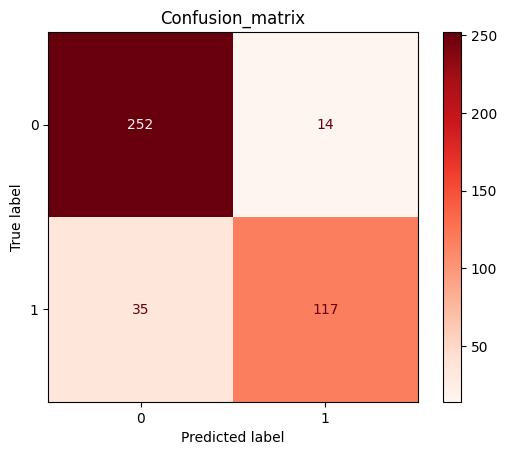

In [31]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Reds', values_format='d', xticks_rotation='horizontal')
plt.title('Confusion_matrix')
plt.show()